# CellXGo_10X

## Setup environment
Anadata requires numpy 2. Therefore a environment was build for this project namely anadata

conda activate anadata

jupyter notebook

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from itertools import compress

## Load data
Change to dataframe with gene name as column name, and cell name as row name

In [4]:
adata_new = ad.read_h5ad("../Data/a5fcffc0-71c0-4363-85a3-6f6928457387.h5ad")  # this is a 10X snRNAseq data
#print(adata_new.var_names)
#print(adata_new.obs_names)
df_cellXGene=pd.DataFrame(adata_new.X, index = adata_new.obs.index)
#df_cellXGene.columns = adata_new.var_names
print(df_cellXGene.head())


                                                                      0
AAAGAACGTCCGAAGA-1-0    (0, 3)\t0.009999999776482582\n  (0, 7)\t0.12...
AAAGTGACACAAATGA-1-0    (0, 3)\t0.009999999776482582\n  (0, 7)\t0.18...
AACAACCGTGTAACGG-1-0    (0, 3)\t0.019999999552965164\n  (0, 7)\t0.33...
AATGGCTCAGAGGACT-1-0    (0, 3)\t0.019999999552965164\n  (0, 7)\t0.23...
ACATCCCGTCTCGGAC-1-0    (0, 3)\t0.009999999776482582\n  (0, 7)\t0.27...


## Sort genes into high, medium, and low expression catogories

Series([], dtype: float64)
Series([], dtype: float64)
Series([], dtype: float64)


/var/folders/rb/0cxxs_352dv50wvkzghy7pj4000dkm/T/ipykernel_12321/3675320243.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  gene_mean=df_cellXGene.mean()


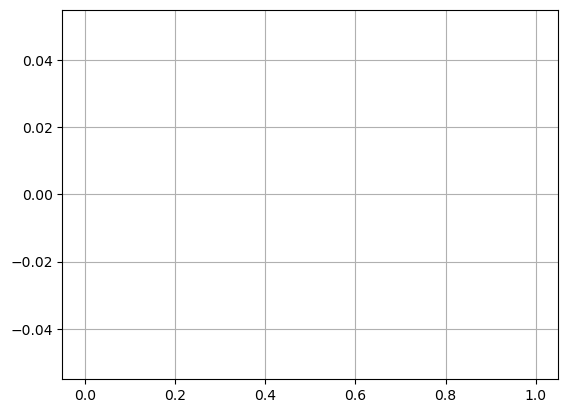

In [21]:
gene_mean=df_cellXGene.mean()
print(gene_mean)
gene_sort=gene_mean.sort_values(ascending=False)
gene_rank=gene_mean.rank(ascending=False)
gene_sort.hist(bins=100)
print(gene_sort)
print(gene_sort.head())  # highest expression genes
#print(gene_sort.tail())  # No expression genes

#print(gene_sort.head(4000)) # 75 precentile expression
#print(gene_sort.head(8000)) # 50 precentile expression
#print(gene_sort.head(12000)) # 25% percentile expression

In [7]:
# histogram of the expression levels at the highest, 75% percetile, 50% percentile


df_cellXGene.hist(column=["MALAT1","SNHG14","NRXN1"], bins=100,layout=(1, 3), figsize=(15, 5))
df_cellXGene.hist(column=["RPL26","ZBTB43","FGGY"], bins=100,layout=(1, 3), figsize=(15, 5))
df_cellXGene.hist(column=["SYT9","SPTBN2","CYC1"], bins=100,layout=(1, 3), figsize=(15, 5))

plt.xlabel('log2 of read counts',ha='center')
plt.ylabel('Frequency')



KeyError: "None of [Index(['MALAT1', 'SNHG14', 'NRXN1'], dtype='object')] are in the [columns]"

## Replace Zero with Nan, then calculate the mean

In [ ]:
df_noZero = df_cellXGene.replace(0, np.nan, inplace=False)
noZeromean = df_noZero.mean(skipna=True)
noZeromean.hist(bins=100)
noZeromean_sorted = noZeromean.sort_values(ascending=False)

#print(noZeromean_sorted.head(4000)) # 75 precentile expression
#print(noZeromean_sorted.head(8000)) # 50 precentile expression
#print(noZeromean_sorted.head(12000)) # 25% percentile expression

In [ ]:
# histogram of the expression levels at the highest, 75% percetile, 50% percentile, 25% percentile

df_noZero.hist(column=["MALAT1","SNHG14", "NRXN1"], bins=100,layout=(1, 3), figsize=(15, 5))
df_noZero.hist(column=["ITGB1","RABGGTA", "SYT17"], bins=100,layout=(1, 3), figsize=(15, 5))
df_noZero.hist(column=["ZNF718","MRPL34", "MT1E"], bins=100,layout=(1, 3), figsize=(15, 5))
df_noZero.hist(column=["ZNF689","MAVS", "ANKRD34C_AS1"], bins=100,layout=(1, 3), figsize=(15, 5))
plt.xlabel('log2 of read counts',ha='center')
plt.ylabel('Frequency')



In [ ]:
noZero25thpercentile = np.nanpercentile(noZeromean, 25)

noZero75thpercentile = np.nanpercentile(noZeromean, 75)
print(noZero25thpercentile, noZero75thpercentile)
# (df_noZeromean > noZero25thpercentile)
# (df_noZeromean < noZero75thpercentile)
df_25 = noZeromean[(noZeromean > 3.36)]
#print(def_25)
#and (df_noZeromean < 4.62)]
df_25To75 = df_25[(df_25 < 4.62)]
df_25To75.describe()
#3.3652830123901367 4.625155448913574


# Transfer cellXGene to binary

In [ ]:


adata_new.X[adata_new.X<1] = 0
adata_new.X[adata_new.X>=1] = 1
adata_new.X=adata_new.X.astype(int)



# Transfer cellXGene to cellTypeXGene

In [ ]:
bi_cellXGene = pd.DataFrame(adata_new.X,index = adata_new.obs.index )
bi_cellXGene.columns = adata_new.var_names
bi_cellXGene["cluster"] = adata_new.obs["cluster"]

#print(bi_cellXGene.head())
df_cellType=bi_cellXGene.groupby(["cluster"]).mean()
#print(df_cellType.head())

# Generate the gene list for goEnrichment 

Generate the gene list for each cluster including the gene expressed in more than 50% cells.

In [ ]:
l=list((adata_new.var).index)
for i in range(len(df_cellType.index)):
    row0=list(df_cellType.iloc[i]>0.5)
    cell_type=df_cellType.index[i]
    gene_list=list(compress(l, row0))
    print(len(set(gene_list)))
    with open(cell_type+"filtered_list.txt", "w") as f:
        f.write(cell_type+"\n")
        for item in gene_list:
            f.write(item+"\n")